### Goals of this notebook:
### 1. Preprocesses the data to prepare for modeling
### 2. Modeling using a number of different models


In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

## I. Preprocessing
We get the data ready to model by dropping some features, creating dummy variables for catagorical features, and scaling the features.

In [2]:
import pickle
os.chdir("C:\Springboard\Github\Capstone2_cust\Intermediate_Data")

In [3]:
# load picked version of X
X = pickle.load(open("X1.pkl", "rb"))
# look at the first 10 rows of this file
X.head(10)

,first_total,Marketing_first,first_items,first_order,server,Vendor,Source,Area_Code,Ship_Zip,lead_sku,weekday,mon,first_tot_lg,first_it_lg
1,145.58,1,2,2019-11-26 21:44:16+00:00,custom,1.0,web,404,30087,other,Tuesday,November,2.163102,0.30103
2,137.55,0,5,2019-11-26 20:52:08+00:00,custom,1.0,web,845,12545,other,Tuesday,November,2.138461,0.69897
3,22.98,1,2,2019-11-26 18:12:04+00:00,custom,1.0,web,262,53402,ROUTEINS10,Tuesday,November,1.361350,0.30103
4,28.00,0,1,2019-08-07 18:14:49+00:00,custom,0.0,web,617,01983,BEM1003,Wednesday,August,1.447158,0.00000
5,12.00,1,1,2019-08-07 18:05:28+00:00,custom,0.0,web,740,43143,other,Wednesday,August,1.079181,0.00000
6,42.00,0,2,2019-08-07 03:45:52+00:00,custom,0.0,web,701,58801,BES1006,Wednesday,August,1.623249,0.30103
7,27.20,1,1,2019-08-06 22:00:54+00:00,custom,0.0,web,754,33026,BEM6001,Tuesday,August,1.434569,0.00000
8,22.00,1,2,2019-08-06 20:22:25+00:00,custom,0.0,web,unknown,01880,BES5001,Tuesday,August,1.342423,0.30103
9,100.00,1,5,2019-08-06 19:59:05+00:00,custom,0.0,web,617,01880,BEM1007,Tuesday,August,2.000000,0.69897
10,36.64,1,2,2019-08-06 19:14:49+00:00,custom,0.0,web,626,92887,BEM1007,Tuesday,August,1.563955,0.30103


That looks pretty good. Let's review what each column means: <br>
- first_total: total $ spend on first order <br>
- Marketing_first: whether they accept marketing on the first order <br>
- first_items: number of items on first order <br>
- first_order: date-time of first order <br>
- server: domain name of the customer email server <br>
- vendor: 0 = first order from company; 1 = first order from outside source <br>
- Source: web or iphone
- Area_Code: area code of order placed
- Ship_Zip: zip code of shipping address
- lead_sku: name of SKU that was lead item on purchase
- weekday: day of week first order was placed
- mon: month that first order was placed
- first_tot_lg: log of first order total
- first_it_lg: log of number of items in first order <br>
<br>
The values for some of these catagorical features need to be converted to numbers

In [4]:
X['Source'].value_counts()

web        33949
1356615     5423
294517       273
457101        67
580111        16
412739         2
Name: Source, dtype: int64

In [5]:
# let's drop first order item log
X.drop('first_it_lg', axis=1, inplace=True)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39730 entries, 1 to 39770
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   first_total      39730 non-null  float64            
 1   Marketing_first  39730 non-null  int64              
 2   first_items      39730 non-null  int64              
 3   first_order      39730 non-null  datetime64[ns, UTC]
 4   server           39730 non-null  object             
 5   Vendor           39730 non-null  float64            
 6   Source           39730 non-null  object             
 7   Area_Code        39730 non-null  object             
 8   Ship_Zip         39730 non-null  object             
 9   lead_sku         39730 non-null  object             
 10  weekday          39730 non-null  object             
 11  mon              39730 non-null  object             
 12  first_tot_lg     39730 non-null  float64            
dtypes: datetime64[ns

traditional regression can't handle date-time, so we'll drop that

In [7]:
# drop date-time
X.drop('first_order', axis=1, inplace=True)

features that need dummy variables:
- server
- source
- Area_Code
- Ship_Zip
- lead_sku
- weekday
- mon <br>
<br>
Let's look at the size of these

In [8]:
X['server'].nunique()

26

In [9]:
X['Source'].nunique()

6

In [10]:
X['Area_Code'].nunique()

373

This is too man catagorical variables for this feature. I wonder if there are high concentrations of purchases in some zip codes that we could account for

In [11]:
X['Area_Code'].value_counts().head(20)

unknown    21387
949          273
714          204
720          161
760          155
310          148
214          144
512          144
817          139
801          135
757          132
917          131
208          131
503          130
909          130
704          129
916          129
360          128
619          127
303          121
Name: Area_Code, dtype: int64

There are 40k customers, so the largest area code makes up 0.68% of total orders. I think this feature is too small and would add unnecessary dimensions. We will drop.

In [12]:
X.drop('Area_Code', axis=1, inplace=True)

In [13]:
X['Ship_Zip'].nunique()

15930

That is way too many features. Unless they are very concentrated in a few zip codes, we'll drop it.

In [14]:
X['Ship_Zip'].value_counts().head(20)

unknown    48
92692      48
92688      48
92691      46
28532      41
92694      40
92630      39
92627      38
92656      31
92679      29
92677      27
92675      25
92672      24
92626      23
80013      22
92629      22
92592      22
92660      21
93551      20
79936      20
Name: Ship_Zip, dtype: int64

In [15]:
# drop that feature
X.drop('Ship_Zip', axis=1, inplace=True)

In [16]:
X['lead_sku'].nunique()

26

We know how many variables for days of the week and month there are. This means we should see: <br>
- server: 26
- source: 6
- lead_sku: 26
- weekday: 7
- mon: 12 <br>
- total: 77 more freatures <br>
<br>
That seems reasonable

In [17]:
# dummy for server ##
dfs = X['server']
dummy_server = pd.get_dummies(dfs)
X = pd.concat([X.drop('server', axis=1), dummy_server], axis=1)

In [18]:
# Dummy for Source
dfs = X['Source']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('Source', axis=1), dummy_source], axis=1)

In [19]:
# Dummy for lead_sku
dfs = X['lead_sku']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('lead_sku', axis=1), dummy_source], axis=1)

In [20]:
# Dummy for weekday
dfs = X['weekday']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('weekday', axis=1), dummy_source], axis=1)

In [21]:
# Dummy for weekday
dfs = X['mon']
dummy_source = pd.get_dummies(dfs)
X = pd.concat([X.drop('mon', axis=1), dummy_source], axis=1)
X

,first_total,Marketing_first,first_items,Vendor,first_tot_lg,aim.com,aol.com,att.net,bellsouth.net,charter.net,...,December,February,January,July,June,March,May,November,October,September
1,145.58,1,2,1.0,2.163102,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,137.55,0,5,1.0,2.138461,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,22.98,1,2,1.0,1.361350,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28.00,0,1,0.0,1.447158,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,12.00,1,1,0.0,1.079181,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39766,27.98,0,2,1.0,1.446848,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39767,59.97,0,2,1.0,1.777934,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39768,54.97,1,2,1.0,1.740126,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39769,90.68,0,3,1.0,1.957512,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


That looks good. Let's load Y.

In [22]:
# load picked version of X
y = pickle.load(open("Y1.pkl", "rb"))
# look at the first 10 rows of this file
y.head(10)

1     2.163102
2     2.138461
3     1.361350
4     1.447158
5     1.079181
6     1.623249
7     1.434569
8     1.342423
9     2.000000
10    1.563955
Name: life_lg, dtype: float64

In [23]:
# let's scale the X values
# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler = preprocessing.StandardScaler().fit(X)
# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled=scaler.transform(X)

In [24]:
# let's split the training and test sets
from sklearn.model_selection import train_test_split

# Get the 1-dimensional flattened array of our response variable y by calling the ravel() function on y
y = y.ravel()

# let's do the split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=1)

In [25]:
# let's quickly check that the Y means to make sure the data sets are similiar
y_train.mean(), y_test.mean()

(1.8158008483225205, 1.8162965793223824)

Those look reasonably close. <br>
<br>
That is the end of preprocessing. Time to model. 

## II. Modeling
We will try a few different models: <br>
- Linear Regression
- Random Forest Regressor
- Dummy Model (assume every customer is average)
- Gradient Boost Regression

In [26]:
# create list to track model performance
perform = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE'])

#### Model 1: Linear Regression

In [27]:
#first model from X-train
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [28]:
# predicted results from the first model on the X_test values
y_pred = model.predict(X_test)
# Mean Absolute Error
m1_MAE = mean_absolute_error(y_test, y_pred)
m1_MAE

50444183616.4365

In [29]:
# Mean Squared Error
m1_MSE = mean_squared_error(y_test, y_pred)
m1_MSE

1.0109758020001125e+25

These values seem extremely high. I want to look at some of the values in the model really quick.

In [30]:
print(lm.intercept_)

10088836725.066


That seems way off with linear regression. Let's see if Random Forest Regressor looks any better

In [31]:
# root mean squared error
m1_RMSE = m1_MSE**0.5

In [32]:
perform = perform.append({'Model':'Linear Regression', 'MAE':m1_MAE, 'MSE':m1_MSE, 'RMSE':m1_RMSE}, ignore_index=True)

#### 2. Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
# using a minimum sample of 40 or 1/1000th of the total number of customers
regr = RandomForestRegressor(min_samples_leaf=40, random_state=33)
model_rf = regr.fit(X_train,y_train)
y_pred_rf = regr.predict(X_test)

In [35]:
# Mean Absolute Error
m2_MAE = mean_absolute_error(y_test, y_pred_rf)
m2_MAE

0.18474874822669013

In [36]:
# Mean Squared Error
m2_MSE = mean_squared_error(y_test, y_pred_rf)
m2_MSE

0.06807649032099493

In [37]:
# root mean squared error
m2_RMSE = m2_MSE**0.5
m2_RMSE

0.2609147184828693

That is so much better! <br>
Let's look at the importance of each feature

In [38]:
coff_m2 = pd.DataFrame(model_rf.feature_importances_, X.columns, columns=['Importance'])
coff_m2.sort_values('Importance', ascending=False).head(20)

,Importance
first_tot_lg,0.510678
first_total,0.430523
November,0.011758
1356615,0.007362
first_items,0.003863
gmail.com,0.003772
December,0.002964
Marketing_first,0.002945
January,0.002182
July,0.002089


These are good see. <br>
We may want to use these values to eliminate some variable from the regression model, but first let's compare the RMSE and AMSE to a dummy model that just assumes very customer is average 

In [39]:
# find the least important values
m2_unimportant = coff_m2.sort_values('Importance', ascending=True).head(25)
m2_unimportant

,Importance
BEM1007,0.0
me.com,0.0
msn.com,0.0
optonline.net,0.0
rocketmail.com,0.0
sbcglobal.net,0.0
vendor,0.0
mac.com,0.0
verizon.net,0.0
ymail.com,0.0


All of these features have literally no importance on this Random Forest Regressor. We will use these later to drop from the features so that we can build a model that works with the important features only and doesn't waste time on these features.

In [40]:
perform = perform.append({'Model':'Random Forest 1', 'MAE':m2_MAE, 'MSE':m2_MSE, 'RMSE':m2_RMSE}, ignore_index=True)

#### 3. Dummy Model (average)

In [41]:
# assume the model is the average of the training data (we know this value)
y_pred_dm = np.full(y_test.size, y_train.mean())
# Mean Absolute Error
m3_MAE = mean_absolute_error(y_test, y_pred_dm)
m3_MAE

0.29065108266816125

In [42]:
# Mean Squared Error
m3_MSE = mean_squared_error(y_test, y_pred_dm)
m3_MSE

0.14451655741084168

In [43]:
# root mean squared error
m3_RMSE = m3_MSE**0.5
m3_RMSE

0.38015333407829227

These are worse than the Random Forest Regressor, so that's a good thing

In [44]:
# difference in root mean squared error between the two models
diff = m3_RMSE - m2_RMSE
diff

0.11923861559542298

In [45]:
# lifetime dollar value of that difference
10**diff

1.3159476582939336

That is honestly not that impressive, but is still better than the dummy model. <br>
<br>
Let's see if we can use those results to improve the models after we try the Gradient Boosting Regression

In [46]:
perform = perform.append({'Model':'Dummy Model (average)', 'MAE':m3_MAE, 'MSE':m3_MSE, 'RMSE':m3_RMSE}, ignore_index=True)

#### 4. Gradient Boosting Regression

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
# create regressor
reg_gb = GradientBoostingRegressor(min_samples_leaf=40, random_state=0)
# fit the regressor
model_gb = reg_gb.fit(X_train,y_train)
# use regressor to predict on test data
y_pred_gb = regr.predict(X_test)
# compare test data for a score - Mean Absolute Error
m4_MAE = mean_absolute_error(y_test, y_pred_gb)
m4_MAE

0.18474874822669013

In [49]:
# Mean Squared Error
m4_MSE = mean_squared_error(y_test, y_pred_gb)
m4_MSE

0.06807649032099493

In [50]:
# root mean squared error
m4_RMSE = m4_MSE**0.5
m4_RMSE

0.2609147184828693

These results are extremely good; they are very similar to the results from the Random Forest Regressor. We probably should improve these two models to get the best results. Let's look at the importance of each feature in the GB Regressor

In [51]:
coff_m4 = pd.DataFrame(model_gb.feature_importances_, X.columns, columns=['Importance'])
coff_m4.sort_values('Importance', ascending=False).head(20)

,Importance
first_tot_lg,0.523446
first_total,0.424205
November,0.010217
1356615,0.006939
first_items,0.004168
294517,0.004014
457101,0.002968
July,0.002540
BES1011,0.002495
December,0.002075


In [52]:
# find the LEAST important features and eliminate those features from the X data set; then run the models again
m4_unimportant = coff_m4.sort_values('Importance', ascending=True).head(39)
m4_unimportant

,Importance
BEM1007,0.0
vendor,0.0
verizon.net,0.0
windstream.net,0.0
yahoo.com,0.0
ymail.com,0.0
412739,0.0
BEM6008,0.0
BEM6728,0.0
BEM6729,0.0


All of these features have literally no importance on this Gradient Boosting Regressor. We will use these to drop the features so that we can build a model that works with the important features only and doesn't waste time on these features.

In [53]:
perform = perform.append({'Model':'Gradient Boost 1', 'MAE':m4_MAE, 'MSE':m4_MSE, 'RMSE':m4_RMSE}, ignore_index=True)
perform

,Model,MAE,MSE,RMSE
0,Linear Regression,5.044418e+10,1.010976e+25,3.179585e+12
1,Random Forest 1,1.847487e-01,6.807649e-02,2.609147e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
3,Gradient Boost 1,1.847487e-01,6.807649e-02,2.609147e-01


### III. Remove unimportant features
The results from the first round of modeling were good, but there was a lot of unimportant features that were still considered by the models. Let's eliminate those features and see if we the models perform better.

In [54]:
# create a list of the unimportant features
unimport = list(set(m4_unimportant.index.tolist()) | set(m2_unimportant.index.tolist()))
# remove unimportant features from Gradient Boosting
X1 = X.drop(unimport, axis=1)
X1

,first_total,Marketing_first,first_items,Vendor,first_tot_lg,custom,gmail.com,hotmail.com,1356615,294517,...,December,February,January,July,June,March,May,November,October,September
1,145.58,1,2,1.0,2.163102,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,137.55,0,5,1.0,2.138461,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,22.98,1,2,1.0,1.361350,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28.00,0,1,0.0,1.447158,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,12.00,1,1,0.0,1.079181,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39766,27.98,0,2,1.0,1.446848,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39767,59.97,0,2,1.0,1.777934,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39768,54.97,1,2,1.0,1.740126,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39769,90.68,0,3,1.0,1.957512,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


That eliminated a lot of features and took us down to just 40 features! Excellent! <br>
<br>
Let's model with those features

In [55]:
# let's scale the X values
scaler1 = preprocessing.StandardScaler().fit(X1)
X1_scaled=scaler1.transform(X1)

# split the X and y values again
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=0.20, random_state=1)
# check the mean values of the y to make sure this is a good split
y_train.mean(), y_test.mean()


(1.8158008483225205, 1.8162965793223824)

#### 5. Linear regression on reduced feature data set

In [56]:
# try standard linear regression on the data set with less features
lm5 = linear_model.LinearRegression()
model5 = lm5.fit(X1_train,y_train)

In [57]:
# predicted results from the first model on the X_test values
y5_pred = model5.predict(X1_test)
# Mean Absolute Error
m5_MAE = mean_absolute_error(y_test, y5_pred)

In [58]:
# Mean Squared Error
m5_MSE = mean_squared_error(y_test, y5_pred)

In [59]:
# Root Mean Squared Error
m5_RMSE = m5_MSE**0.5

In [60]:
perform = perform.append({'Model':'Linear Regression 2', 'MAE':m5_MAE, 'MSE':m5_MSE, 'RMSE':m5_RMSE}, ignore_index=True)
perform

,Model,MAE,MSE,RMSE
0,Linear Regression,5.044418e+10,1.010976e+25,3.179585e+12
1,Random Forest 1,1.847487e-01,6.807649e-02,2.609147e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
3,Gradient Boost 1,1.847487e-01,6.807649e-02,2.609147e-01
4,Linear Regression 2,1.858921e-01,6.770492e-02,2.602017e-01


This updated version of linear regression actually performed better than the first attempt at Random Forest Regression or Gradient Boost Regression. That's great to see that eliminating those features lead to such improvement.

#### 6. Random Forest Regression with reduced features

In [61]:
# using a minimum sample of 40 or 1/1000th of the total number of customers
regr1 = RandomForestRegressor(min_samples_leaf=40, random_state=33)
model1_rf = regr.fit(X1_train,y_train)
y_pred1_rf = regr.predict(X1_test)

In [62]:
# Mean Absolute Error
m6_MAE = mean_absolute_error(y_test, y_pred1_rf)
# Mean Squared Error
m6_MSE = mean_squared_error(y_test, y_pred1_rf)
# root mean squared error
m6_RMSE = m6_MSE**0.5
# add to performance DF
perform = perform.append({'Model':'Random Forest 2', 'MAE':m6_MAE, 'MSE':m6_MSE, 'RMSE':m6_RMSE}, ignore_index=True)
perform


,Model,MAE,MSE,RMSE
0,Linear Regression,5.044418e+10,1.010976e+25,3.179585e+12
1,Random Forest 1,1.847487e-01,6.807649e-02,2.609147e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
3,Gradient Boost 1,1.847487e-01,6.807649e-02,2.609147e-01
4,Linear Regression 2,1.858921e-01,6.770492e-02,2.602017e-01
5,Random Forest 2,1.846553e-01,6.810615e-02,2.609715e-01


these values look good, but similar to previous models

#### 7. Gradient Boost with Reduced Features

In [63]:
# create regressor
reg1_gb = GradientBoostingRegressor(min_samples_leaf=40, random_state=0)
model1_gb = reg_gb.fit(X1_train,y_train)
# use regressor to predict on test data
y_pred1_gb = regr.predict(X1_test)
# compare test data for a score - Mean Absolute Error
m7_MAE = mean_absolute_error(y_test, y_pred1_gb)
# Mean Squared Error
m7_MSE = mean_squared_error(y_test, y_pred1_gb)
# root mean squared error
m7_RMSE = m7_MSE**0.5
perform = perform.append({'Model':'Gradient Boost 2', 'MAE':m7_MAE, 'MSE':m7_MSE, 'RMSE':m7_RMSE}, ignore_index=True)
perform


,Model,MAE,MSE,RMSE
0,Linear Regression,5.044418e+10,1.010976e+25,3.179585e+12
1,Random Forest 1,1.847487e-01,6.807649e-02,2.609147e-01
2,Dummy Model (average),2.906511e-01,1.445166e-01,3.801533e-01
3,Gradient Boost 1,1.847487e-01,6.807649e-02,2.609147e-01
4,Linear Regression 2,1.858921e-01,6.770492e-02,2.602017e-01
5,Random Forest 2,1.846553e-01,6.810615e-02,2.609715e-01
6,Gradient Boost 2,1.846553e-01,6.810615e-02,2.609715e-01


These look like great models (except for the first Linear Regression). Let's see if tuning the hyperparameters can make them better.

## IV. Hyperparameter Tuning

We took a guess at a good hyperparameter of 40 for the minimum number of leaves per node. That looked like a good start relative to the Linear Regression results. Instead, we should also consider multiple values for the hyperparameter for both the Gradient Boost and Random Forest Regressions

#### 8. Random Forest with Hyperparameter Tuning

In [73]:
import random
node_size = random.sample(range(10,1000), 20)

perform_h = pd.DataFrame(columns=['Model', 'Node_size', 'MAE', 'MSE', 'RMSE'])

# loops through the number of leaves
for n in node_size:
    reg_h = RandomForestRegressor(min_samples_leaf=n, random_state=33)
    model_rf_h = reg_h.fit(X1_train,y_train)
    y_pred1_rf_h = reg_h.predict(X1_test)
    # Mean Absolute Error
    MAE1 = mean_absolute_error(y_test, y_pred1_rf_h)
    # Mean Squared Error
    MSE1 = mean_squared_error(y_test, y_pred1_rf_h)
    # root mean squared error
    RMSE1 = MSE1**0.5
    # add to performance DF
    perform_h = perform_h.append({'Model':'Random Forest', 'Node_size':n, 'MAE':MAE1, 'MSE': MSE1, 'RMSE':RMSE1}, ignore_index=True)

perform_h

,Model,Node_size,MAE,MSE,RMSE
0,Random Forest,73,0.185846,0.068381,0.261498
1,Random Forest,709,0.192131,0.070129,0.264818
2,Random Forest,724,0.192239,0.070196,0.264946
3,Random Forest,610,0.191573,0.069930,0.264443
4,Random Forest,300,0.189256,0.069151,0.262967
5,Random Forest,433,0.190752,0.069639,0.263893
6,Random Forest,598,0.191510,0.069913,0.264410
7,Random Forest,913,0.192557,0.070440,0.265404
8,Random Forest,107,0.186597,0.068430,0.261592
9,Random Forest,391,0.190251,0.069466,0.263564


These all look extremely similiar, let's plot the results

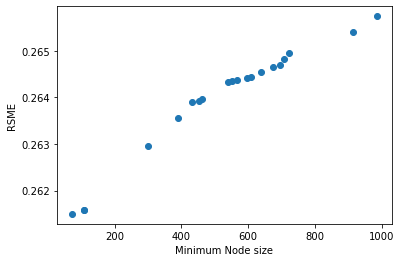

In [75]:
# plot the minimum node size versus the RSME
plt.scatter(perform_h['Node_size'], perform_h['RMSE'])
plt.xlabel('Minimum Node size')
plt.ylabel('RSME')
plt.show()

That looks like it trends downwards with smaller minimum node size, as it's allowed to fit the model more closely to the data. Let's try a different range of values to select from and iterate one more time on that hyperparameter

In [78]:
# much smaller minimum node size 
node_size = random.sample(range(5,30), 20)

# we'll add on to the existing DF so we get a better look at the full curve

# loops through the number of leaves
for n in node_size:
    reg_h = RandomForestRegressor(min_samples_leaf=n, random_state=33)
    model_rf_h = reg_h.fit(X1_train,y_train)
    y_pred1_rf_h = reg_h.predict(X1_test)
    # Mean Absolute Error
    MAE1 = mean_absolute_error(y_test, y_pred1_rf_h)
    # Mean Squared Error
    MSE1 = mean_squared_error(y_test, y_pred1_rf_h)
    # root mean squared error
    RMSE1 = MSE1**0.5
    # add to performance DF
    perform_h = perform_h.append({'Model':'Random Forest', 'Node_size':n, 'MAE':MAE1, 'MSE': MSE1, 'RMSE':RMSE1}, ignore_index=True)

perform_h

,Model,Node_size,MAE,MSE,RMSE
0,Random Forest,73,0.185846,0.068381,0.261498
1,Random Forest,709,0.192131,0.070129,0.264818
2,Random Forest,724,0.192239,0.070196,0.264946
3,Random Forest,610,0.191573,0.069930,0.264443
4,Random Forest,300,0.189256,0.069151,0.262967
5,Random Forest,433,0.190752,0.069639,0.263893
6,Random Forest,598,0.191510,0.069913,0.264410
7,Random Forest,913,0.192557,0.070440,0.265404
8,Random Forest,107,0.186597,0.068430,0.261592
9,Random Forest,391,0.190251,0.069466,0.263564


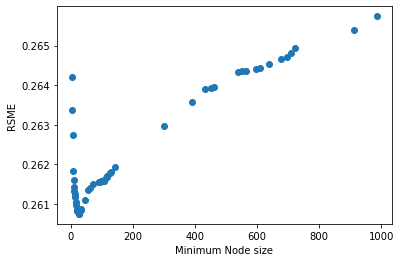

In [79]:
# plot the minimum node size versus the RSME
plt.scatter(perform_h['Node_size'], perform_h['RMSE'])
plt.xlabel('Minimum Node size')
plt.ylabel('RSME')
plt.show()

That is the dip that I wanted to see to consider a balance between under and over-fitting to the data. Let's find the best value.

In [81]:
perform_h.sort_values('RMSE', ascending=True).head(10)

,Model,Node_size,MAE,MSE,RMSE
25,Random Forest,26,0.183825,0.067990,0.260749
52,Random Forest,26,0.183825,0.067990,0.260749
42,Random Forest,27,0.183901,0.067997,0.260763
31,Random Forest,28,0.183991,0.068002,0.260771
54,Random Forest,28,0.183991,0.068002,0.260771
47,Random Forest,23,0.183687,0.068021,0.260808
57,Random Forest,25,0.183818,0.068022,0.260811
22,Random Forest,25,0.183818,0.068022,0.260811
49,Random Forest,29,0.184057,0.068023,0.260812
41,Random Forest,21,0.183620,0.068030,0.260827


It looks like 26 is the best minimum node size for Random Forest Regression with this data

#### 9. Gradient Boosting with Hyperparameter Tuning

Let's do the same hyperparameter tuning, but with Gradient Boosting. We may consider a different parameter to change for GB

In [90]:
# much smaller minimum node size 
learn_rt = [random.random() for x in range(20)]

# we'll add on to the existing DF so we get a better look at the full curve
perform_gb = pd.DataFrame(columns=['Model', 'Learning_rate', 'MAE', 'MSE', 'RMSE'])

# loops through the number of leaves
for r in learn_rt:
    reg_gb = GradientBoostingRegressor(learning_rate=r, random_state=0)
    model_gb = reg_gb.fit(X1_train,y_train)
    # use regressor to predict on test data
    y_pred_gb = regr.predict(X1_test)
    # Mean Absolute Error
    MAE1 = mean_absolute_error(y_test, y_pred_gb)
    # Mean Squared Error
    MSE1 = mean_squared_error(y_test, y_pred_gb)
    # root mean squared error
    RMSE1 = MSE1**0.5
    # add to performance DF
    perform_gb = perform_gb.append({'Model':'Gradient Boost', 'Learning_rate':r, 'MAE':MAE1, 'MSE': MSE1, 'RMSE':RMSE1}, ignore_index=True)

perform_gb.sort_values('RMSE', ascending=True).head(10)

,Model,Learning_rate,MAE,MSE,RMSE
0,Gradient Boost,0.127730,0.184655,0.068106,0.260972
17,Gradient Boost,0.056014,0.184655,0.068106,0.260972
16,Gradient Boost,0.672297,0.184655,0.068106,0.260972
15,Gradient Boost,0.769311,0.184655,0.068106,0.260972
14,Gradient Boost,0.222383,0.184655,0.068106,0.260972
13,Gradient Boost,0.523420,0.184655,0.068106,0.260972
12,Gradient Boost,0.551342,0.184655,0.068106,0.260972
11,Gradient Boost,0.895799,0.184655,0.068106,0.260972
10,Gradient Boost,0.241575,0.184655,0.068106,0.260972
9,Gradient Boost,0.026208,0.184655,0.068106,0.260972


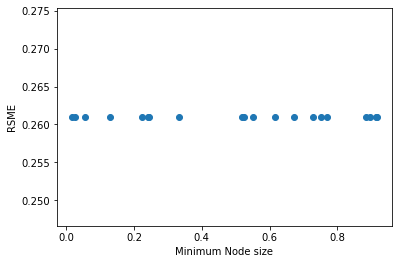

In [92]:
# plot the minimum node size versus the RSME
plt.scatter(perform_gb['Learning_rate'], perform_gb['RMSE'])
plt.xlabel('Learning Rate')
plt.ylabel('RSME')
plt.show()